In [1]:
import os;
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
import tensorflow as tf;
import numpy as np;
import scipy as sp;
import matplotlib.pyplot

In [4]:
# q1 : output tensor dimension 1
# q2 : output tensor dimension 2
# e1 : penalty
# e2 : penalty
# activation: activation function
# bias: add bias term

class ProjectionLayer(tf.keras.layers.Layer):
    
    def __init__(self, q1,q2, regularization=False, rate=0.5):
        super(ProjectionLayer, self).__init__()
        self.q1 = int(q1);
        self.q2 = int(q2);
        self.e1 = 10 ** -6;
        self.e2 = 10 ** -6;
        self.reg = regularization;
        self.rate = rate;
    
    def build(self, input_shape):
        p1 = int(input_shape[1]);
        p2 = int(input_shape[2]);
        ch = int(input_shape[3]);
        # copy
        self.p1 = p1;
        self.p2 = p2;
        self.ch = ch;
        
        # create training parameters
        #_W1 = np.random.uniform(low=-5.0, high=5.0, size=[p1,self.q1,ch]);
        #initW1 = tf.constant_initializer(_W1);
        #_W2 = np.random.uniform(low=-5.0, high=5.0, size=[p2,self.q2,ch]);
        #initW2 = tf.constant_initializer(_W2);
        
        self.W1 = self.add_weight("W1",shape=[p1, self.q1, ch],initializer='normal', trainable=True);
        self.W2 = self.add_weight("W2",shape=[p2, self.q2, ch],initializer='normal', trainable=True);
        
        #self.W1 = self.add_weight("W1",shape=[p1, self.q1, ch],initializer='normal', trainable=True, regularizer=tf.contrib.layers.l2_regularizer(0.03));
        #self.W2 = self.add_weight("W2",shape=[p2, self.q2, ch],initializer='normal', trainable=True, regularizer=tf.contrib.layers.l2_regularizer(0.03));
        self.output_dim = [self.q1, self.q2, self.ch];
        super(ProjectionLayer, self).build(input_shape);
        
    def call(self, x_):
        n   =  tf.shape(x_)[0];
        p1 = self.p1;
        p2 = self.p2;
        c   = self.ch;
        q1 = self.q1;
        q2 = self.q2;
    
        W1 = tf.transpose(self.W1, perm=[2,0,1]);
        W2 = tf.transpose(self.W2, perm=[2,0,1]);
        W1T = tf.transpose(self.W1, perm=[2,1,0]);
        W2T = tf.transpose(self.W2, perm=[2,1,0]);
    
        Iq1 = tf.eye(q1);
        Iq2 = tf.eye(q2);
        Iq1 = tf.expand_dims(Iq1,0); # (1,q1,q1)
        Iq2 = tf.expand_dims(Iq2,0); # (1,q2,q2)
        
        Iq1c = tf.tile(Iq1, [c, 1,1]);
        Iq2c = tf.tile(Iq2, [c, 1,1]);
        
        M1 = tf.add(tf.linalg.matmul(W1T,W1) , Iq1c * self.e1);
        M2 = tf.add(tf.linalg.matmul(W2T,W2) , Iq2c * self.e2);
        
        sqrtM1 = tf.linalg.sqrtm(M1);
        sqrtM2 = tf.linalg.sqrtm(M2);
        
        G1 = tf.linalg.inv(sqrtM1);
        G2 = tf.linalg.inv(sqrtM2);
        
        A = tf.linalg.matmul(W1,G1); # c, p1, q1
        AT = tf.transpose(A, perm=[0,2,1]);  # c,q1,p1
        C = tf.expand_dims(AT,0); #(1,c,q1,p1)
        Cn = tf.tile(C,[n,1,1,1]); # (n,c,q1,p1)
        B = tf.linalg.matmul(W2,G2); # c, p2, q2
        D = tf.expand_dims(B,0); # (1,c,p2,q2)
        Dn = tf.tile(D,[n,1,1,1]); # (n,c,p2,q2)
        x = tf.transpose(x_,perm=[0,3,1,2]); # n,p1,p2,c -> n,c,p1,p2
        z = tf.linalg.matmul(Cn,tf.matmul(x,Dn));
        # reconstruction error
        if self.reg == True:
            CnT = tf.transpose(Cn,perm=[0,1,3,2]);
            DnT = tf.transpose(Dn,perm=[0,1,3,2]);
            v = tf.linalg.matmul(CnT,tf.linalg.matmul(z,DnT)); # (n,c,p1,p2)
            self.add_loss(self.rate * tf.math.exp(tf.reduce_mean(tf.math.squared_difference(x,v)))); # we use exp()  for transformation
        # end of reconstruction error
        
        z = tf.transpose(z,perm=[0,2,3,1]); # n,c,q1,q2-> n,q1,q2,c 
        return z;

In [5]:
batch_size = 100;
num_classes = 10;
epochs = 10;
# prepare data
# mnist
#(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data();
# fashon mnist
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data();


img_rows, img_cols = 28, 28


if tf.keras.backend.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples');
print(x_test.shape[0], 'test samples');
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

60000 train samples
10000 test samples


In [6]:
#### My Model  with Projection Layer ####
#### With Regularization ####
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3,3),strides=1, padding='same', activation='relu',input_shape=input_shape))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='valid'));
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3,3),strides=1, padding='same', activation='linear'))
model.add(ProjectionLayer(7,7,True, 0.5))
model.add(tf.keras.layers.ReLU());
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(160, activation='relu'))
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.RMSprop(), metrics=['accuracy'])

#
# if you want to start training
#

history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
# save weights
model.save_weights('projection-layer_weights.h5');

#
# if you wish to load weights from the file
#

#model.load_weights('projection-layer_weights.h5')

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 57s 953us/sample - loss: 0.6936 - accuracy: 0.9452 - val_loss: 0.5685 - val_accuracy: 0.9818
Epoch 2/10
60000/60000 [==============================] - 57s 942us/sample - loss: 0.5611 - accuracy: 0.9826 - val_loss: 0.5464 - val_accuracy: 0.9862
Epoch 3/10
60000/60000 [==============================] - 57s 956us/sample - loss: 0.5400 - accuracy: 0.9886 - val_loss: 0.5390 - val_accuracy: 0.9875
Epoch 4/10
60000/60000 [==============================] - 57s 958us/sample - loss: 0.5311 - accuracy: 0.9912 - val_loss: 0.5331 - val_accuracy: 0.9911
Epoch 5/10
60000/60000 [==============================] - 57s 947us/sample - loss: 0.5244 - accuracy: 0.9931 - val_loss: 0.5417 - val_accuracy: 0.9865
Epoch 6/10
60000/60000 [==============================] - 59s 991us/sample - loss: 0.5209 - accuracy: 0.9939 - val_loss: 0.5322 - val_accuracy: 0.9909
Epoch 7/10
60000/60000 [====================

In [8]:
# model summary
model.summary();

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
projection_layer (Projection (None, 7, 7, 32)          6272      
_________________________________________________________________
re_lu (ReLU)                 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1568)              0         
_________________________________________________________________
dense (Dense)                (None, 160)               2

In [10]:
# Without Regularization
model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.Conv2D(32, kernel_size=(3,3),strides=1, padding='same', activation='relu',input_shape=input_shape))
model2.add(tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='valid'));
model2.add(tf.keras.layers.Conv2D(32, kernel_size=(3,3),strides=1, padding='same', activation='linear'))
model2.add(ProjectionLayer(7,7,False))
model2.add(tf.keras.layers.ReLU());
model2.add(tf.keras.layers.Flatten())
model2.add(tf.keras.layers.Dense(160, activation='relu'))
model2.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
model2.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.RMSprop(), metrics=['accuracy'])
history2 = model2.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_test, y_test))
score2 = model2.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score2[0])
print('Test accuracy:', score2[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 54s 902us/sample - loss: 0.1858 - accuracy: 0.9419 - val_loss: 0.0599 - val_accuracy: 0.9816
Epoch 2/10
60000/60000 [==============================] - 53s 887us/sample - loss: 0.0632 - accuracy: 0.9802 - val_loss: 0.0482 - val_accuracy: 0.9836
Epoch 3/10
60000/60000 [==============================] - 53s 878us/sample - loss: 0.0430 - accuracy: 0.9863 - val_loss: 0.0396 - val_accuracy: 0.9874
Epoch 4/10
60000/60000 [==============================] - 54s 895us/sample - loss: 0.0313 - accuracy: 0.9905 - val_loss: 0.0324 - val_accuracy: 0.9889
Epoch 5/10
60000/60000 [==============================] - 55s 914us/sample - loss: 0.0252 - accuracy: 0.9918 - val_loss: 0.0347 - val_accuracy: 0.9888
Epoch 6/10
60000/60000 [==============================] - 52s 858us/sample - loss: 0.0196 - accuracy: 0.9939 - val_loss: 0.0327 - val_accuracy: 0.9897
Epoch 7/10
60000/60000 [====================

In [8]:
# Visualization
projection_layer_name = 'projection_layer';
conv2d_layer_name = 'conv2d';

# obtain layer
hidden_projection_layer = tf.keras.Model(inputs=model.input, outputs=model.get_layer(projection_layer_name).output)
hidden_conv2d_layer = tf.keras.Model(inputs=model.input, outputs=model.get_layer(conv2d_layer_name).output)

# compute outputs of projection_layer
Z = hidden_projection_layer.predict(x_test[0:100]);

# compute outpus of conv2d layer
X = hidden_conv2d_layer.predict(x_test[0:100]);

# load weights of projection layer
projection_weights = hidden_projection_layer.get_weights();
W1 = projection_weights[2];
W2 = projection_weights[3];
# projection_weights[0].shape : parameter of the previous conv2D layer
# projection_weights[1].shape : parameter of the previsou conv2D layer



In [9]:
# Visualization tool 
def projection_restore(Z,W1,W2):
    # obtain n,p1,p2,q1,q2:
    n = Z.shape[0];
    q1 = Z.shape[1];
    q2 = Z.shape[2];
    p1 = W1.shape[0];
    p2 = W2.shape[0];
    c = W1.shape[2];
    
    Iq1 = np.eye(q1);
    Iq2 = np.eye(q2);
    Iq1 = np.expand_dims(Iq1,axis=0);
    Iq2 = np.expand_dims(Iq2,axis=0);
    Iq1 = np.tile(Iq1,(c,1,1));
    Iq2 = np.tile(Iq2,(c,1,1));
    
    Z = np.transpose(Z,(0,3,1,2)); # [n,q1,q2,c] ---> [n,c,q1,q2]
    W1 = np.transpose(W1,(2,0,1)); # [p1,q1,c] --> [c,p1,q1]
    W1T = np.transpose(W1,(0,2,1)); # -->[c,q1,p1]
    M1 = np.matmul(W1T,W1) + 0.001*Iq1;
    M1q = np.zeros((c,q1,q1));
    for i in range(c):
        M1q[i] = sp.linalg.sqrtm(M1[i])
    G1 = np.linalg.inv(M1q);
    
    W1G1 = np.matmul(W1,G1);
    
    W2 = np.transpose(W2,(2,0,1));
    W2T = np.transpose(W2,(0,2,1)); # [p2,q2,c] --> [c,p2,q2]
    M2 = np.matmul(W2T,W2) + 0.001*Iq2;
    M2q = np.zeros((c,q2,q2));
    for i in range(c):
        M2q[i] = sp.linalg.sqrtm(M2[i]);
    G2 = np.linalg.inv(M2q);
    W2G2 = np.matmul(W2,G2);
    W2G2T = np.transpose(W2G2,(0,2,1));

    
    W1G1n = np.expand_dims(W1G1,axis=0); # [1,c,p1,q1];
    W1G1n = np.tile(W1G1n,(n,1,1,1)); #[n,c,p1,q1]
    W2G2Tn = np.expand_dims(W2G2T,axis=0); # [1,c,p2,q2];
    W2G2Tn = np.tile(W2G2Tn,(n,1,1,1));
    
    X = np.matmul(np.matmul(W1G1n,Z),W2G2Tn);
    return np.transpose(X,(0,2,3,1));

In [10]:
# restore from n=0 -> 99
X_tilde = projection_restore(Z, W1,W2);
X_tilde.shape

(100, 28, 28, 32)

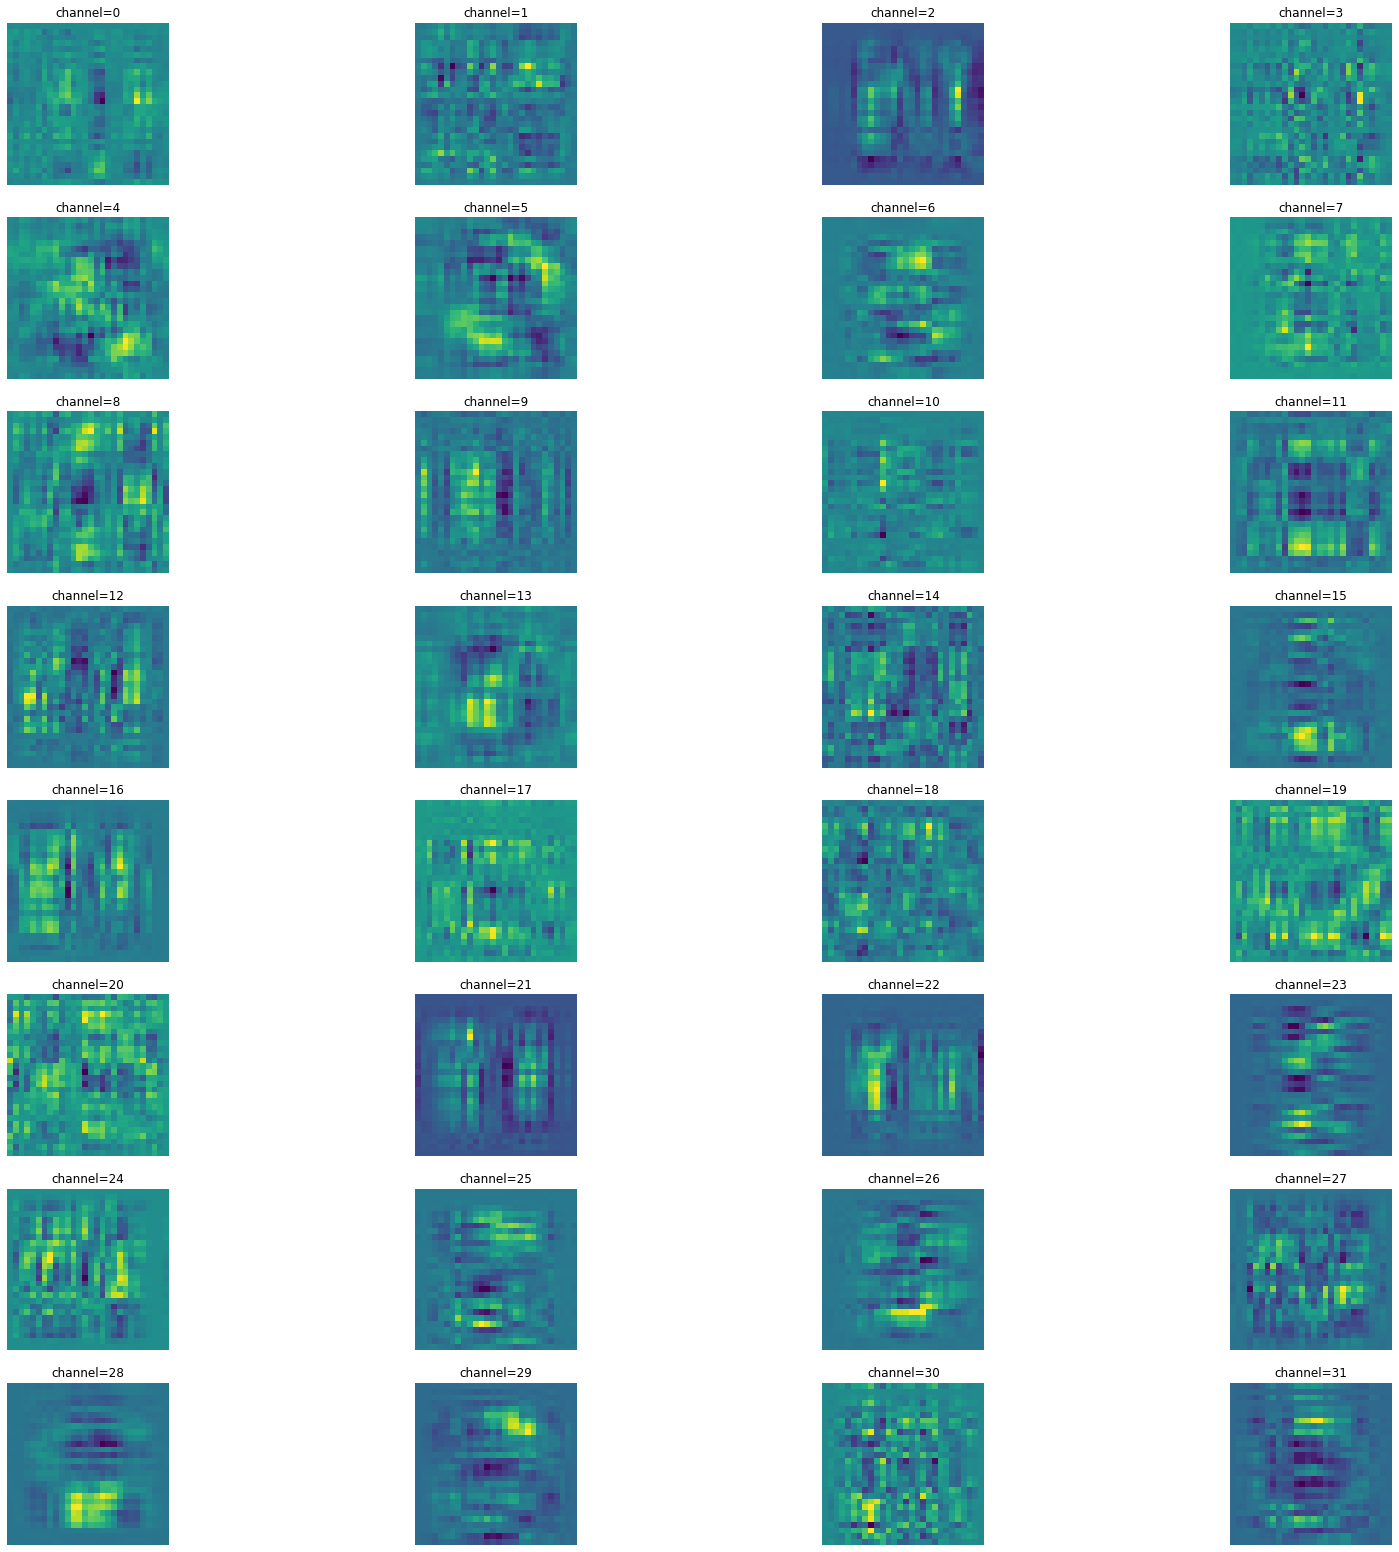

In [11]:
# show projected layer output 
n = 10; # observation
fig = matplotlib.pyplot.figure(figsize=(28, 28))
for c in range(32):
    ax = fig.add_subplot(8, 4, c+1)
    ax.imshow(X_tilde[n,:,:,c])
    ax.set_axis_off()
    ax.set_title("channel={}".format(c))
matplotlib.pyplot.show();
#matplotlib.pyplot.matshow(np.reshape(x_test[n],(28,28)),cmap='gray');

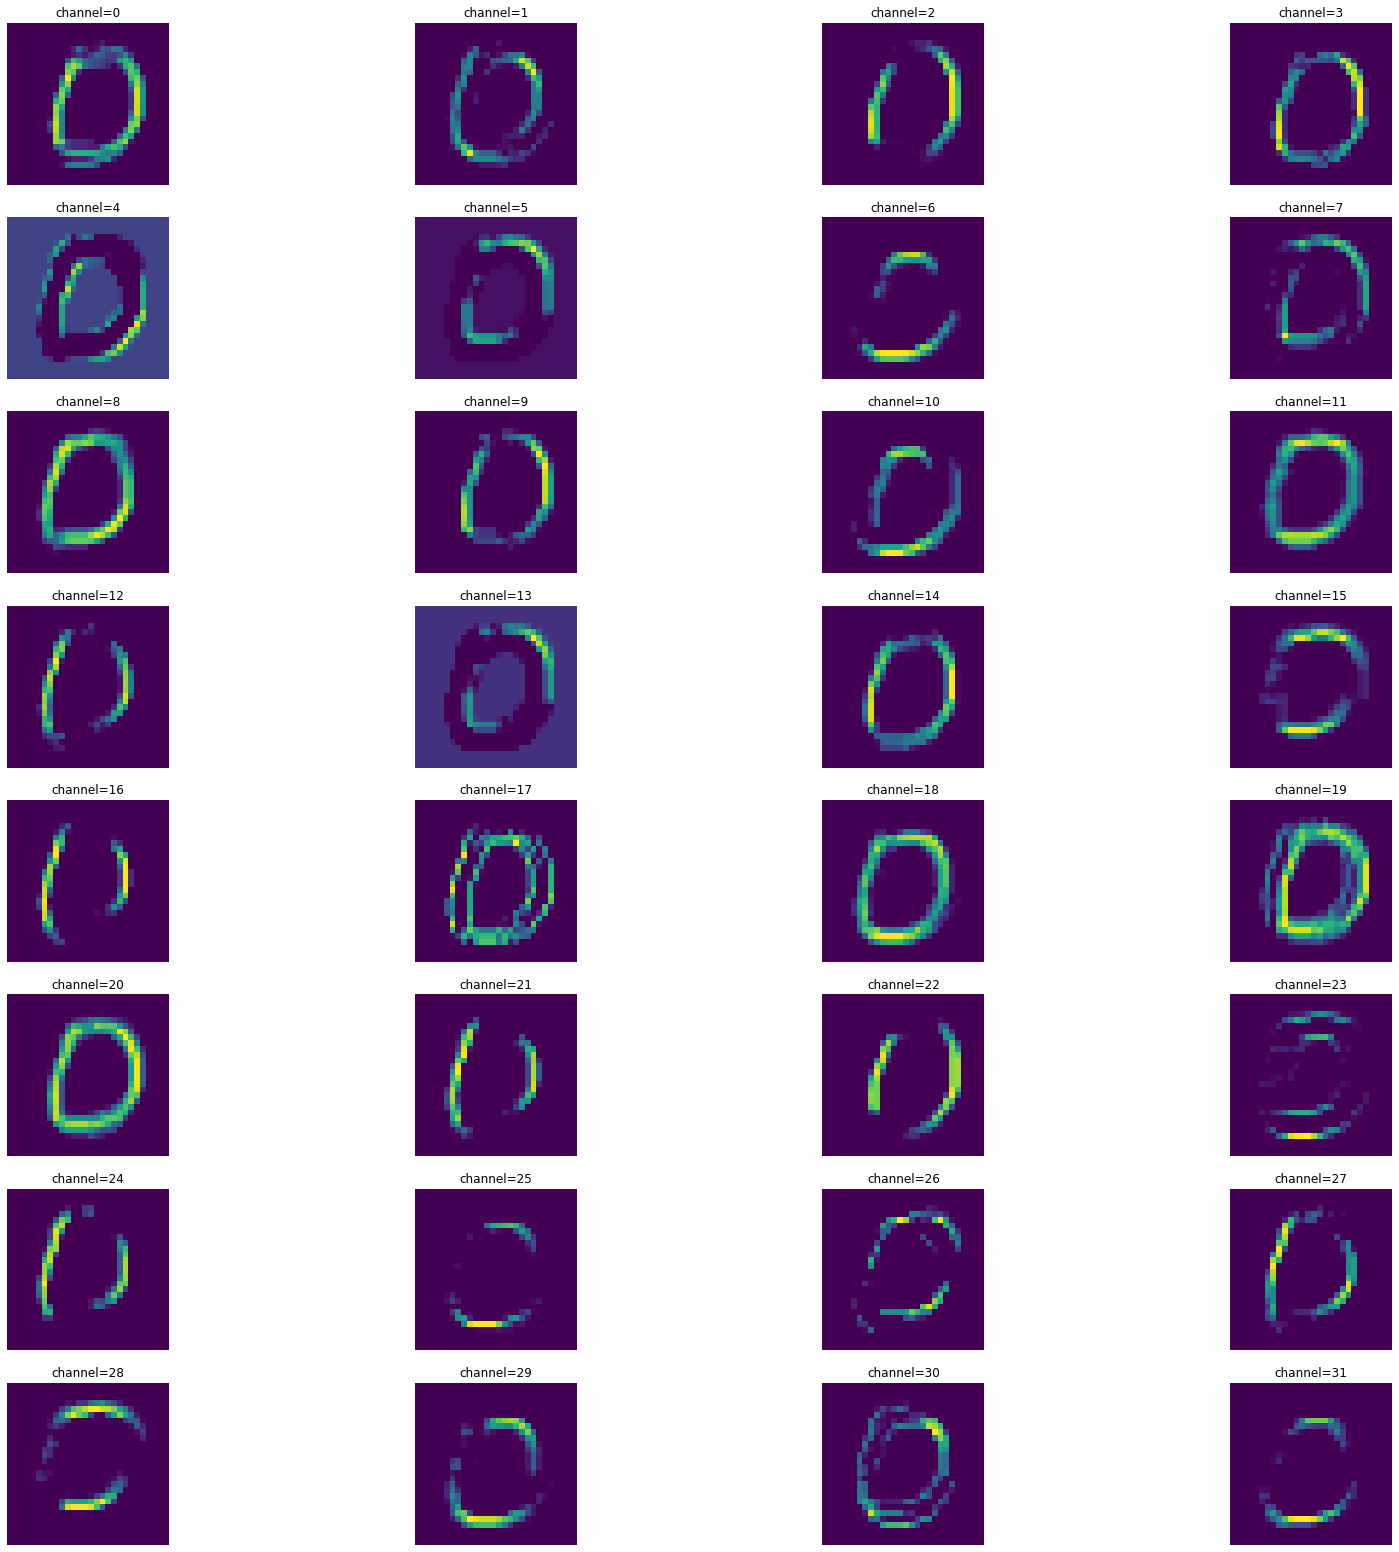

In [12]:
# show conv2d output
n = 10; # observation
fig = matplotlib.pyplot.figure(figsize=(28, 28))
for c in range(32):
    ax = fig.add_subplot(8, 4, c+1)
    ax.imshow(X[n,:,:,c])
    ax.set_axis_off()
    ax.set_title("channel={}".format(c))
matplotlib.pyplot.show();
#matplotlib.pyplot.matshow(np.reshape(x_test[n],(28,28)),cmap='gray');

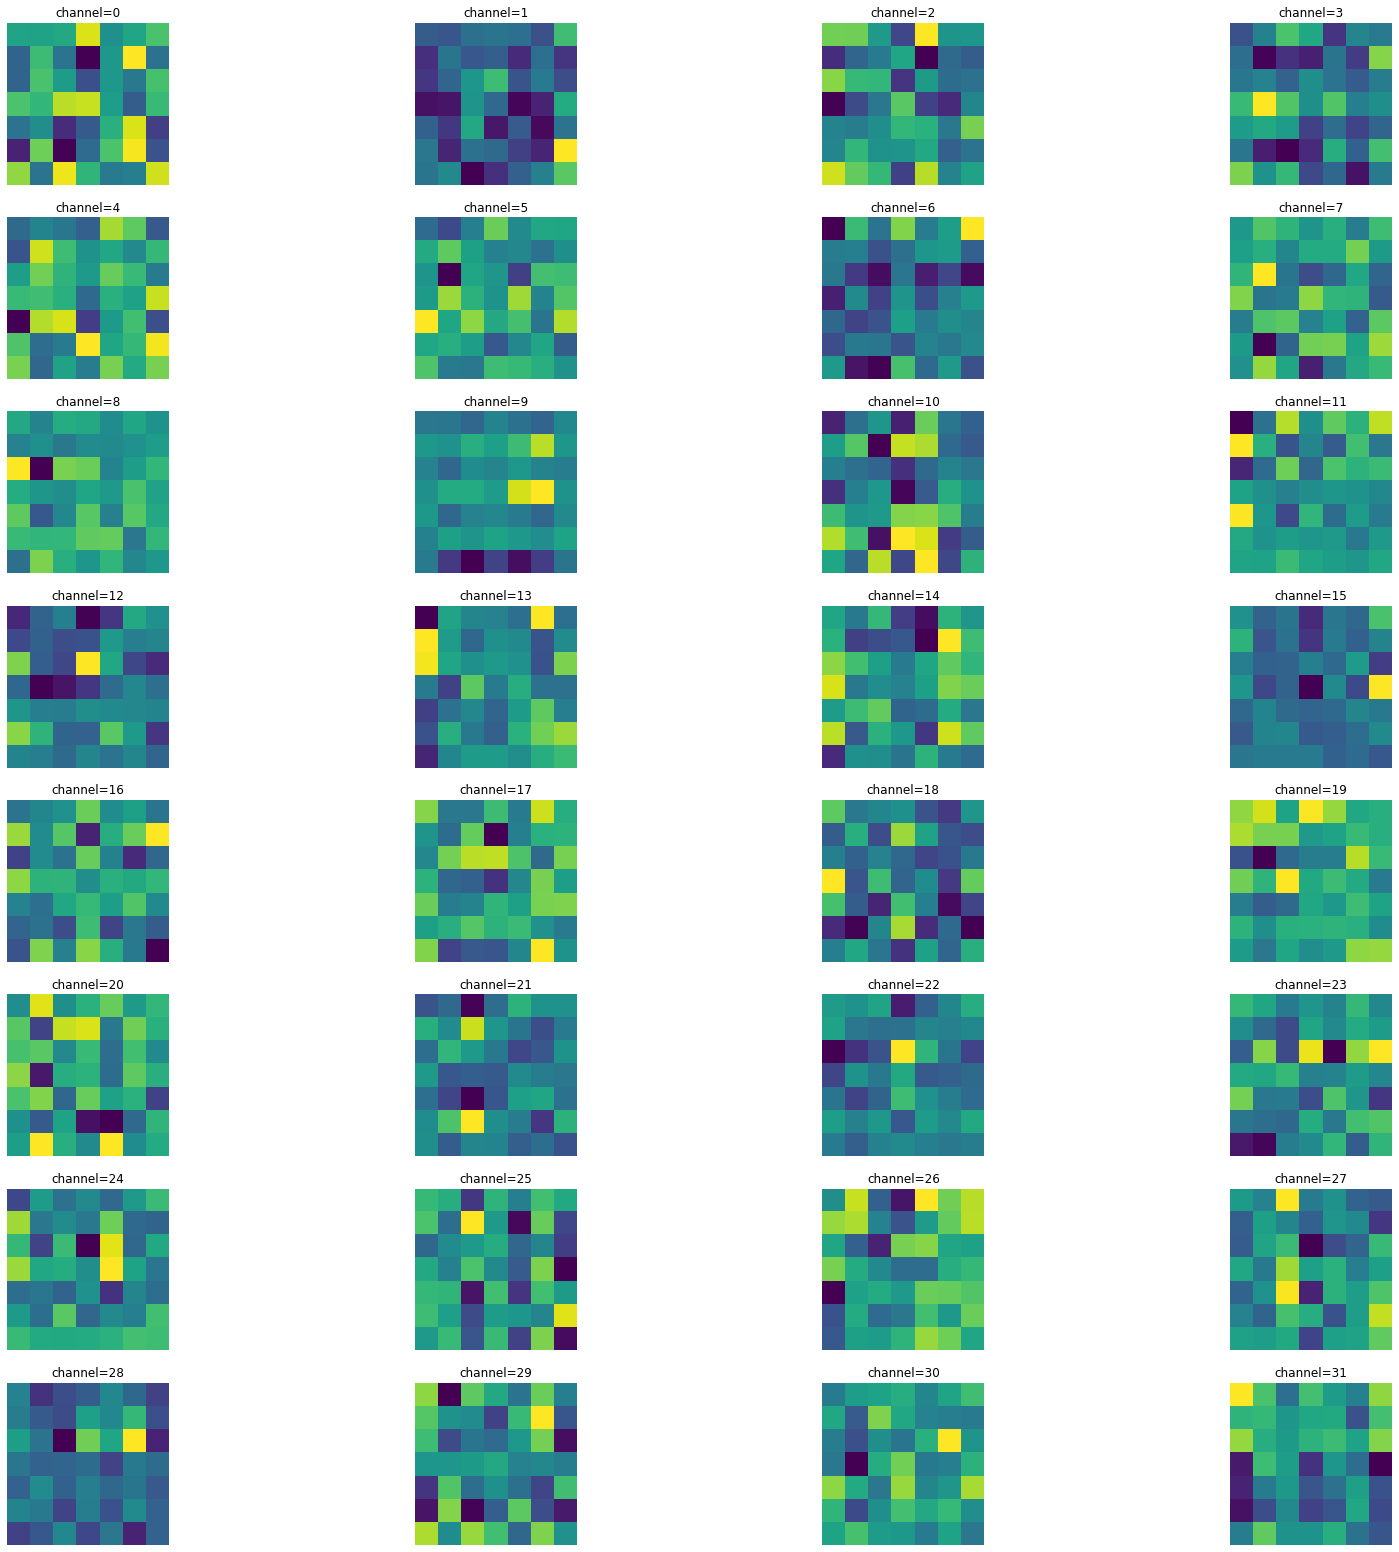

In [12]:
# show img 5x5
n = 10;
fig = matplotlib.pyplot.figure(figsize=(28, 28))
for c in range(32):
    ax = fig.add_subplot(8, 4, c+1)
    ax.imshow(Z[n,:,:,c])
    ax.set_axis_off()
    ax.set_title("channel={}".format(c))
matplotlib.pyplot.show()

In [13]:
# compute squared error
num_obs = 100;
num_ch  = 32;
D = X_tilde - X;
loss = np.zeros((num_obs,num_ch),dtype=np.float32);
for i in range(num_obs):
    for j in range(num_ch):
        diff_ij = D[i,:,:,j];
        loss[i,j] = np.sum(np.power(diff_ij.flatten('F'), 2));
        
print("Average Squared Loss : sum of loss / (obs * ch)");
print(np.average(loss));

Average Squared Loss : sum of loss / (obs * ch)
4.9669585
